In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as pylab
import seaborn as sns

import re
import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, GlobalAveragePooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint 
from keras.models import Sequential
import text_preprocessor
from keras.layers import Bidirectional, Conv1D, GlobalMaxPool1D, Dense, GlobalMaxPooling1D, concatenate, \
    GlobalAveragePooling1D, SpatialDropout1D, LSTM
from keras.layers import Embedding

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('/Users/zhaocai/Downloads/courses/MSBD5001_ Foundationsof_Data_Analytics/project_group/all/train.csv')
test_df = pd.read_csv('/Users/zhaocai/Downloads/courses/MSBD5001_ Foundationsof_Data_Analytics/project_group/all/test.csv')

# Word Embeddings
glove_path = '/Users/zhaocai/toxic-comment-classification/glove.6B.300d.txt'

In [3]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [4]:
train_df.describe(include='all')

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571,159571,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
unique,159571,159571,NaN,NaN,NaN,NaN,NaN,NaN
top,b108afc2fd6f8fa3,Support. Ekaterinburg is in far more common us...,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,NaN,NaN,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
test_df.describe(include='all')

,id,comment_text
count,153164,153164
unique,153164,153164
top,245618df6a6bdc01,":Oh for God's sake, put a sock in it."
freq,1,1


In [6]:
print(pd.isnull(train_df).sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [7]:
print(pd.isnull(test_df).sum())

id              0
comment_text    0
dtype: int64


In [8]:
def replace_and_remove(train, test, column_name):
    """ Replaces words and removes special character from text in train, test dataset """
    for dataset in [train, test]:
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('\'ll', ' will'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('\'ve', ' have'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('don\'t', ' do not'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('dont', ' do not'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('aren\'t', ' are not'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('won\'t', ' will not'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('wont', ' will not'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('can\'t', ' cannot'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('cant', ' cannot'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('shan\'t', ' shall not'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('shant', ' shall not'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace('\'m', ' am'))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("doesn't", "does not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("doesnt", "does not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("didn't", "did not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("didnt", "did not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("hasn't", "has not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("hasnt", "has not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("haven't", "have not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("havent", "have not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("wouldn't", "would not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("didn't", "did not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("didnt", "did not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("it's", "it is"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("that's", "that is"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("weren't", "were not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace("werent", "were not"))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace(' u ', ' you '))
        dataset[column_name] = dataset[column_name].apply(lambda x: x.replace(' U ', ' you '))
        dataset[column_name] = dataset[column_name].apply(
        lambda x: re.sub('[()\"\t_\n.,:=!@#$%^&*-/[\]?|1234567890—]', ' ', x).strip())

In [9]:
text_preprocessor.replace_and_remove(train_df, test_df, 'comment_text')

In [10]:
Y = train_df[target_columns]

In [11]:
def embedded_glove_matrix(train, test, column_name, glove_path, embed_size, max_features, max_length):
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(train[column_name])
    X = pad_sequences(tokenizer.texts_to_sequences(train[column_name]), maxlen=max_length)
    X_ = pad_sequences(tokenizer.texts_to_sequences(test[column_name]), maxlen=max_length)
    embeddings_index = {}
    # every word index
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    print(len(word_index))
    embedding_matrix = np.zeros((num_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            break
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, X, X_


In [12]:
max_features =20000
max_features = 20000
max_length = 200
embed_size = 300
batch_size = 32
epochs = 1


In [13]:
tokenizer = Tokenizer(num_words=max_features)

In [14]:
tokenizer.fit_on_texts(train_df['comment_text'])
#tokenizer.fit_on_texts(test_df['comment_text'])

In [15]:
len(tokenizer.word_index)

194770

In [16]:
#tokenizer.fit_on_texts(test_df['comment_text'])

In [17]:
len(tokenizer.word_index)

194770

In [18]:
train_tokenized = tokenizer.texts_to_sequences(train_df['comment_text'])
test_tokenized = tokenizer.texts_to_sequences(test_df['comment_text'])

In [19]:
X = pad_sequences(train_tokenized, maxlen=max_length)
X_ = pad_sequences(test_tokenized, maxlen=max_length)

In [20]:
embedding_index = {}
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        embedding_index[values[0]] = np.asarray(values[1:], dtype='float32')

word_index = tokenizer.word_index

In [21]:
len(word_index)

194770

In [22]:
num_words = max(max_features, len(word_index) + 1)

In [23]:
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    #if i >= max_features:
    #    break
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
inp = Input(shape=(max_length,))
max_features = num_words

In [25]:
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = SpatialDropout1D(0.1)(x)
x = Conv1D(250, kernel_size=3, padding="valid", activation='relu', kernel_initializer='glorot_uniform')(x)
x = concatenate([GlobalMaxPooling1D()(x), GlobalAveragePooling1D()(x)])
x = Dense(6, activation="sigmoid")(x)

In [26]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     58431300    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 198, 250)     225250      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_max

In [28]:
csv_logger = CSVLogger('CNN_log.csv', append=True, separator=',')
checkpoint = ModelCheckpoint('CNN_checkpoint.csv', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-8)

In [29]:
model.fit(X, Y, batch_size=batch_size, epochs=epochs)

Epoch 1/1
159571/159571 [==============================] - 6604s 41ms/step - loss: 0.0519 - acc: 0.9812


In [30]:
model.save_weights('ccn_checkpoint1122_2.csv')

In [31]:
temp = pd.DataFrame(model.predict(X_))

In [32]:
result = temp
sam_result = pd.read_csv('sample_submission.csv')
#result = pd.read_csv('lstm_output.csv')
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
sam_result[target_columns] = result
sam_result.to_csv('cnn_submission1122.csv', index=False)

In [33]:
len(embedding_index.keys())

400000

In [34]:
num_words

194771

In [35]:
embedding_matrix.shape


(194771, 300)

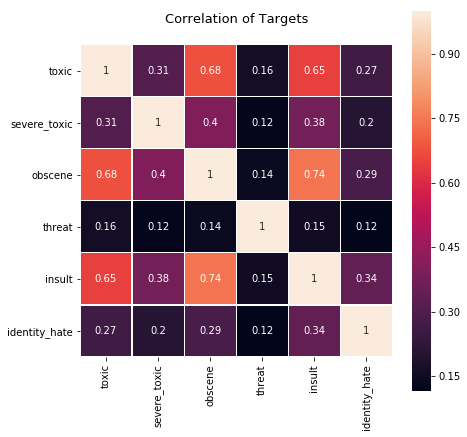

In [70]:
plt.figure(figsize=(7,7))
plt.title('Correlation of Targets',y=1.05,size=13)
sns.heatmap(train_df[target_columns].astype(float).corr(),linewidths=0.2,vmax=1.0,square=True,annot=True)
plt.show()